Install all the dependencies required

In [10]:
!pip uninstall torch -y
!pip uninstall torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

!curl -s https://course.fast.ai/setup/colab | bash
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Uninstalling torch-1.5.0+cu101:
  Successfully uninstalled torch-1.5.0+cu101
Uninstalling torchvision-0.6.0+cu101:
  Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 33.3MB/s 


Updating fastai...
Done.


Setup Google drive to work with Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


Import libraries

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [6]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=637c069b2d1b9e2af2a94caf9854bd19c6a1ea8e91a3e2a5e00026c4e2b166dc
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "nikku23"
os.environ['KAGGLE_KEY'] = "6f730301eef9a886caa98b5a20273cb0"

In [8]:
%cd /content/gdrive/My Drive/fastai-v3
!mkdir test
%cd /content/gdrive/My Drive/fastai-v3/test
!kaggle competitions download -c plant-pathology-2020-fgvc7

/content/gdrive/My Drive/fastai-v3
/content/gdrive/My Drive/fastai-v3/test
 99% 769M/779M [00:13<00:00, 62.6MB/s]
100% 779M/779M [00:13<00:00, 62.1MB/s]


In [0]:
!unzip plant-pathology-2020-fgvc7

In [15]:
%cd /content/gdrive/My Drive/fastai-v3/plant_pathology
import csv

def create_row(old_row):
  row_data = {}
  row_data['image_id'] = old_row['image_id']
  if old_row['healthy'] == '1':
    row_data['class'] = 'healthy'
  elif old_row['multiple_diseases'] == '1':
    row_data['class'] = 'multiple_diseases'
  elif old_row['rust'] == '1':
    row_data['class'] = 'rust'
  elif old_row['scab'] == '1':
    row_data['class'] = 'scab'
  return row_data

def create_file(file_name):
  with open(file_name, 'w') as new_file:
    writer = csv.DictWriter(new_file, fieldnames=['image_id', 'class'])
    with open('train.csv') as old_file:
      for row in csv.DictReader(old_file):
        writer.writerow(create_row(row))

create_file('train_parsed.csv')

/content/gdrive/My Drive/fastai-v3/test


In [0]:
data = ImageDataBunch.from_csv(path=base_dir + "/plant_pathology", folder="images", csv_labels="train_parsed.csv", suffix='.jpg', ds_tfms=get_transforms(), size=244, bs=32).normalize(imagenet_stats)

In [19]:
print(data.classes)

['healthy', 'multiple_diseases', 'rust', 'scab']


In [20]:
print(data.c)

4


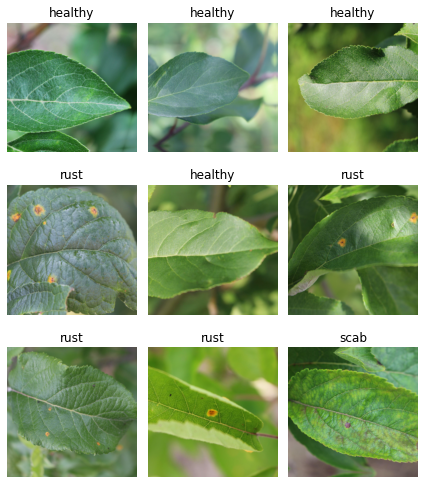

In [5]:
data.show_batch(rows=3, figsize=(6,7))

In [6]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [7]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.193448,0.691477,0.184066,05:55
1,0.821546,0.556713,0.156593,02:19
2,0.608835,0.477355,0.142857,02:17
3,0.473351,0.469416,0.137363,02:16


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1')

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

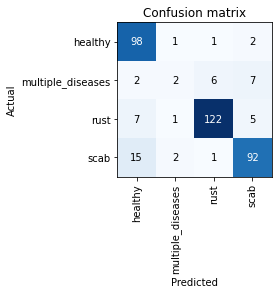

In [16]:
interp.plot_confusion_matrix()

In [0]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


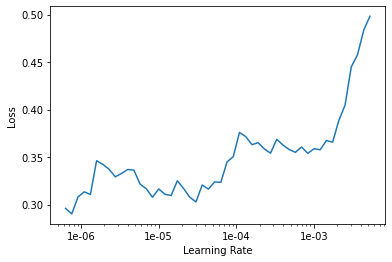

In [20]:
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(2, max_lr=slice(None, e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.392192,0.466866,0.142857,02:23
1,0.376272,0.462376,0.140110,02:20


In [0]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(4, max_lr=slice(1e-06, 1e-04))

epoch,train_loss,valid_loss,error_rate,time
0,0.359904,0.442986,0.137363,02:19
1,0.335100,0.434816,0.131868,02:19
2,0.327194,0.428939,0.131868,02:17
3,0.322476,0.449978,0.131868,02:17


In [27]:
learn.fit_one_cycle(4, max_lr=slice(1e-05, 1e-04))

epoch,train_loss,valid_loss,error_rate,time
0,0.281036,0.400108,0.118132,02:17
1,0.260127,0.411545,0.120879,02:18
2,0.242479,0.364467,0.109890,02:18
3,0.208583,0.385467,0.107143,02:18


In [0]:
learn.save('stage-2')

In [0]:
learn.export()

In [0]:
learn = load_learner('/content/gdrive/My Drive/fastai-v3/plant_pathology')

In [31]:
%cd /content/gdrive/My Drive/fastai-v3/plant_pathology

print_interval = 50
classes = ['healthy', 'multiple_diseases', 'rust', 'scab']
base_path = '/content/gdrive/My Drive/fastai-v3/plant_pathology/images/'

def get_predictions(image_id, image_number):
  predicted_class,_,probabilities = learn.predict(open_image(base_path + image_id + '.jpg'))
  output_dict = {}
  output_dict["image_id"] = image_id
  for idx,clazz in enumerate(classes):
    # add prediction value for each class with 10 digits
    output_dict[clazz] = '{:.10f}'.format(probabilities.numpy()[idx])
  # document progress every [print_interval]th image
  if image_number % print_interval == 0:
    print(image_id + " - " + str(predicted_class) + ' - ' + str(probabilities.numpy()))

  return output_dict

def create_output_csv(input_csv, output_csv):
  with open(output_csv, 'w') as output:
    writer = csv.DictWriter(output, fieldnames=['image_id'] + classes)
    writer.writeheader()
    with open(input_csv) as input:
      # add row for each image with predictions
      for idx,(row) in enumerate(csv.DictReader(input)):
        writer.writerow(get_predictions(row['image_id'], idx))

create_output_csv('test.csv', 'output.csv')

/content/gdrive/My Drive/fastai-v3/plant_pathology
Test_0 - rust - [2.188276e-06 4.288366e-04 9.995690e-01 2.499377e-09]
Test_50 - rust - [6.279021e-06 1.818326e-04 9.998110e-01 9.640695e-07]
Test_100 - scab - [7.144497e-05 1.416782e-03 9.213894e-08 9.985116e-01]
Test_150 - scab - [2.614457e-02 1.948560e-01 7.227184e-04 7.782767e-01]
Test_200 - rust - [1.039910e-06 1.462052e-04 9.998527e-01 6.402391e-08]
Test_250 - healthy - [9.935414e-01 5.994453e-03 3.168076e-04 1.473015e-04]
Test_300 - scab - [3.376140e-02 1.357137e-03 3.899842e-06 9.648775e-01]
Test_350 - scab - [6.822554e-06 4.008117e-03 1.236912e-06 9.959838e-01]
Test_400 - rust - [1.742134e-04 2.147823e-02 9.783434e-01 4.103887e-06]
Test_450 - rust - [3.946047e-05 3.589773e-05 9.999247e-01 7.353343e-10]
Test_500 - rust - [2.185597e-05 2.089847e-05 9.999567e-01 4.352522e-07]
Test_550 - scab - [2.381906e-04 2.012100e-03 1.408855e-06 9.977483e-01]
Test_600 - rust - [1.067924e-08 9.864363e-04 9.990135e-01 4.530194e-10]
Test_650 - ru